In [6]:
from transformers import BertModel,BertTokenizer
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import demoji
import string
import pandas as pd
import demoji
import tqdm.notebook as tq
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report,f1_score

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
df = pd.read_csv("C:/mhBert/Combined Data.csv",delimiter=',',nrows=10000)
df.head(10)


cuda


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
5,5,"every break, you must be nervous, like somethi...",Anxiety
6,6,"I feel scared, anxious, what can I do? And may...",Anxiety
7,7,Have you ever felt nervous but didn't know why?,Anxiety
8,8,"I haven't slept well for 2 days, it's like I'm...",Anxiety
9,9,"I'm really worried, I want to cry.",Anxiety


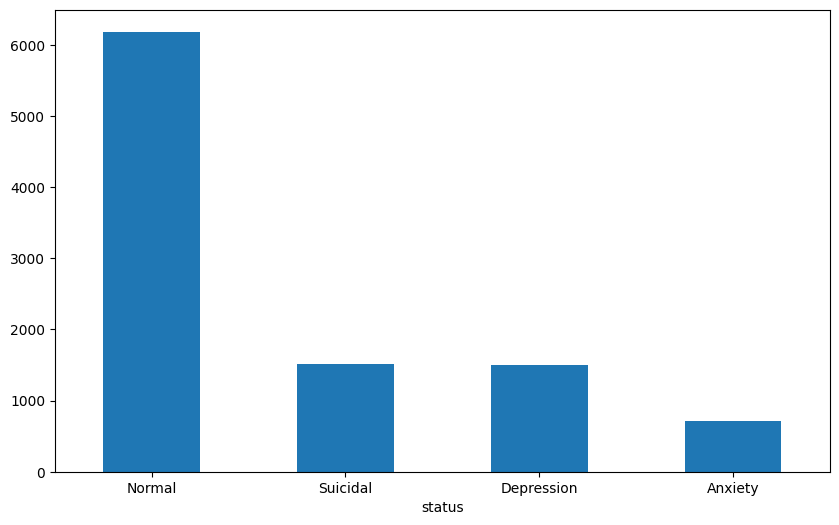

In [7]:

df.drop("Unnamed: 0",inplace=True,axis=1)
df.isnull().sum()
df['statement'] = df['statement'].fillna("")

df.duplicated().sum()
df.drop_duplicates(inplace=True)


plt.figure(figsize=(10,6))
df['status'].value_counts().plot(kind='bar',rot=0)
plt.show()

In [8]:


df['Normal'] = (df['status'] == "Normal").astype(int)
df['Depression'] = (df['status'] == 'Depression').astype(int)
df['Suicidal'] = (df['status'] == 'Suicidal').astype(int)
df['Anxiety'] = (df['status'] == 'Anxiety').astype(int)




df.drop("status",inplace=True,axis=1)

TARGET_LIST = list(df.columns[1:])
print(TARGET_LIST)
df[TARGET_LIST]

['Normal', 'Depression', 'Suicidal', 'Anxiety']


,Normal,Depression,Suicidal,Anxiety
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
9995,0,0,1,0
9996,0,1,0,0
9997,0,0,1,0
9998,0,1,0,0


In [9]:

def clean_text(text):
    
    text = str(text).lower()

    text = re.sub(r'<.*?>', '',text)
    
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    text = demoji.replace(text,'')
    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    
    return text



df['statement'] = df['statement'].apply(clean_text)
df['statement'].head(10)


0                                           oh my gosh
1    trouble sleeping confused mind restless heart ...
2    all wrong back off dear forward doubt stay in ...
3    ive shifted my focus to something else but im ...
4    im restless and restless its been a month now ...
5    every break you must be nervous like something...
6    i feel scared anxious what can i do and may my...
7        have you ever felt nervous but didnt know why
8    i havent slept well for 2 days its like im res...
9                      im really worried i want to cry
Name: statement, dtype: object

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\katsa\AppData\Local\Temp\ipykernel_9864\1529011649.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_tokens)


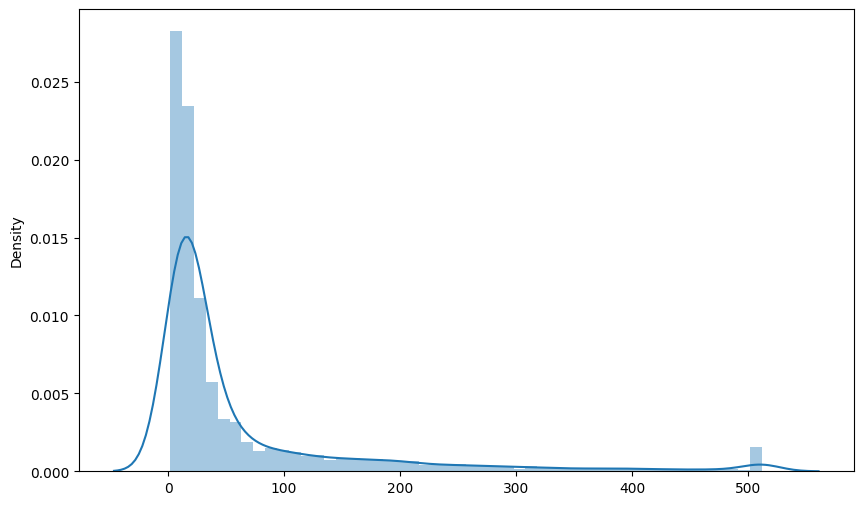

In [10]:


MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME,do_lower_case=True)


sample_tokens = []
for txt in df['statement']:
    tokens = tokenizer.encode(txt, max_length=512)
    sample_tokens.append(len(tokens))


plt.figure(figsize=(10,6))
sns.distplot(sample_tokens)
plt.show()

In [11]:

MAX_LEN = 200


class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self,df,max_len,tokenizer,TARGET_LIST):
        self.df = df
        self.statement = list(df['statement'])
        self.targets = self.df[TARGET_LIST].values
        self.max_len = max_len
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.statement)
    
    def __getitem__(self,idx):
        statement = str(self.statement[idx])
        statement = " ".join(statement.split())
        
        encoder = self.tokenizer.encode_plus(
            statement,
            None,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt',
            )
        
        return {
            "statement":statement,
            "input_ids":encoder['input_ids'].flatten(),
            "attention_mask":encoder['attention_mask'].flatten(),
            "token_type_ids":encoder['token_type_ids'].flatten(),
            "targets":torch.FloatTensor(self.targets[idx])
            }


from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df,test_size=.20,random_state=42)
df_val,df_test = train_test_split(df_test, test_size=.50,random_state=42)







train_dataset = Custom_Dataset(df_train,MAX_LEN,tokenizer,TARGET_LIST)
test_dataset = Custom_Dataset(df_test, MAX_LEN, tokenizer, TARGET_LIST)
val_dataset = Custom_Dataset(df_test, MAX_LEN, tokenizer, TARGET_LIST)


BATCH_SIZE = 4


train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=BATCH_SIZE,num_workers=0)


data= next(iter(train_dataloader))
data.keys()

dict_keys(['statement', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])

In [12]:

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert_model = BertModel.from_pretrained(MODEL_NAME, return_dict=True)
        self.dropout = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert_model(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output


    

model = BertClassifier()
model.to(device)

BertClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [13]:

def loss_fn(outputs,targets):
    return nn.BCEWithLogitsLoss()(outputs,targets)



optimizer = torch.optim.AdamW(model.parameters(),lr=1e-5)

EPOCHS = 4


def train_model(train_dataloader, model, optimizer):
    model.train()
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.train()
    loop = tq.tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True)
    for batch_idx, data in loop:
        input_ids = data['input_ids'].to(device, dtype = torch.long)
        attention_mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)


        outputs = model(input_ids, attention_mask,token_type_ids)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        _, preds = torch.max(outputs, dim=1)
        _, targ = torch.max(targets, dim=1)
        num_samples += len(targ)
        correct_predictions += torch.sum(preds == targ)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


    return model, float(correct_predictions)/num_samples, np.mean(losses)



def eval_model(val_dataloader, model, optimizer):
    model.eval()
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(val_dataloader, 0):
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())


            _, preds = torch.max(outputs, dim=1)
            _, targ = torch.max(targets, dim=1)
            num_samples += len(targ)
            correct_predictions += torch.sum(preds == targ)

    return float(correct_predictions)/num_samples, np.mean(losses)






for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_dataloader, model, optimizer)
    val_acc, val_loss = eval_model(val_dataloader, model, optimizer)

    print(f'train_loss={train_loss*100:.2f}, val_loss={val_loss*100:.2f} train_acc={train_acc*100:.2f}, val_acc={val_acc*100:.2f}')




test_acc,test_loss = eval_model(test_dataloader, model, optimizer)
print(f'testing accuracy: {test_acc*100:.2f}%')
print(f'testing loss: {test_loss*100:.2f}')


Epoch 1/4


  0%|          | 0/1983 [00:00<?, ?it/s]

train_loss=18.79, val_loss=12.36 train_acc=82.79, val_acc=91.03
Epoch 2/4


  0%|          | 0/1983 [00:00<?, ?it/s]

train_loss=11.96, val_loss=13.46 train_acc=90.91, val_acc=90.93
Epoch 3/4


  0%|          | 0/1983 [00:00<?, ?it/s]

train_loss=9.04, val_loss=16.28 train_acc=94.10, val_acc=90.42
Epoch 4/4


  0%|          | 0/1983 [00:00<?, ?it/s]

train_loss=6.43, val_loss=15.58 train_acc=96.31, val_acc=92.74
testing accuracy: 92.74%
testing loss: 15.58


In [14]:


def get_predictions(model, dataloader):
    model.eval()
    
    statements = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in dataloader:
        statement = data["statement"]
        input_ids = data["input_ids"].to(device, dtype = torch.long)
        attention_mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(input_ids, attention_mask, token_type_ids)
        _, preds = torch.max(outputs, dim=1)
        _, targ = torch.max(targets, dim=1)

        statements.extend(statement)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targ)
        
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    target_values = torch.stack(target_values).cpu()
    
    return statements, predictions, prediction_probs, target_values





statements, predictions, prediction_probs, target_values = get_predictions(model, test_dataloader)


print(classification_report(predictions,target_values, target_names=TARGET_LIST))

print(f1_score(predictions, target_values,average='micro'))

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       639
  Depression       0.71      0.82      0.76       122
    Suicidal       0.82      0.75      0.78       160
     Anxiety       0.97      0.97      0.97        71

    accuracy                           0.93       992
   macro avg       0.88      0.88      0.88       992
weighted avg       0.93      0.93      0.93       992

0.9274193548387096


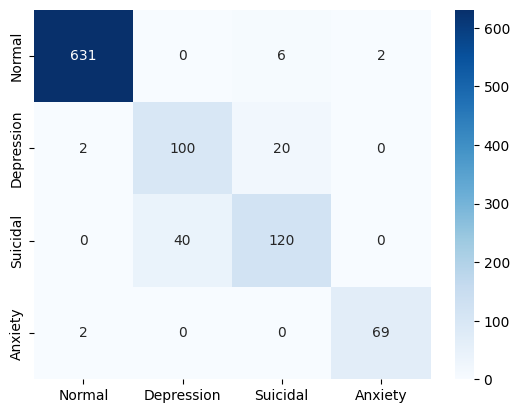

In [15]:
def plt_confusion_matrix(predictions,target_values):
    cm = confusion_matrix(predictions,target_values)
    sns.heatmap(cm, fmt='d',annot=True,cmap="Blues",xticklabels=["Normal","Depression","Suicidal","Anxiety"],yticklabels=["Normal","Depression","Suicidal","Anxiety"])



plt_confusion_matrix(predictions, target_values)


